metrics to compare:
- speed in ms per delta t timestep (fine solver vs end to end) -> scale that to big resolution and say we save x amount of time
- MSE, MAE for each snapshot
- generalization (marmousi and bp dataset, but then own, easier velocities)

In [5]:
from generate_data import wave_util
import time
import torch
import numpy as np
import matplotlib.pyplot as plt
from models import model_end_to_end
from skimage.transform import resize
from models.model_utils import fetch_data_end_to_end
from generate_data.wave_propagation import velocity_verlet_tensor, pseudo_spectral, velocity_verlet

In [6]:
#params
boundary_c = 'absorbing'
dx = 2.0/128.0
dt = dx/20
dX = dx * 2
dT = dt * 4
delta_t_star = .06
T = .6
scaler = 2
n_snaps = 11
Nx,Ny = 128, 128
c_Nx, c_Ny = 64,64

path = "../data/end_to_end_bp_m_200_2000.npz"
loaders = fetch_data_end_to_end([path], shuffle=False, batch_size=1)

setting up data
test data points: 200


In [7]:
# set up models

restr_model1 = model_end_to_end.Restriction_nn(res_scaler = scaler,boundary_c=boundary_c, delta_t_star=delta_t_star, f_delta_x = dX).double()
#restr_model1 = torch.nn.DataParallel(restr_model1)
#restr_model1.load_state_dict(torch.load('../results/run_2/saved_model_end_to_end_unet128_29.pt'))
#restr_model1.eval()

netlist = [
    (r'end-to-end unet 3lvl', restr_model1),
]

for netname,netmodl in netlist:
    model_parameters = filter(lambda p: p.requires_grad, netmodl.parameters())
    params = sum([np.prod(p.size()) for p in model_parameters])
    print(netname,'number of trainable parameters', params)

end-to-end unet 3lvl number of trainable parameters 47170


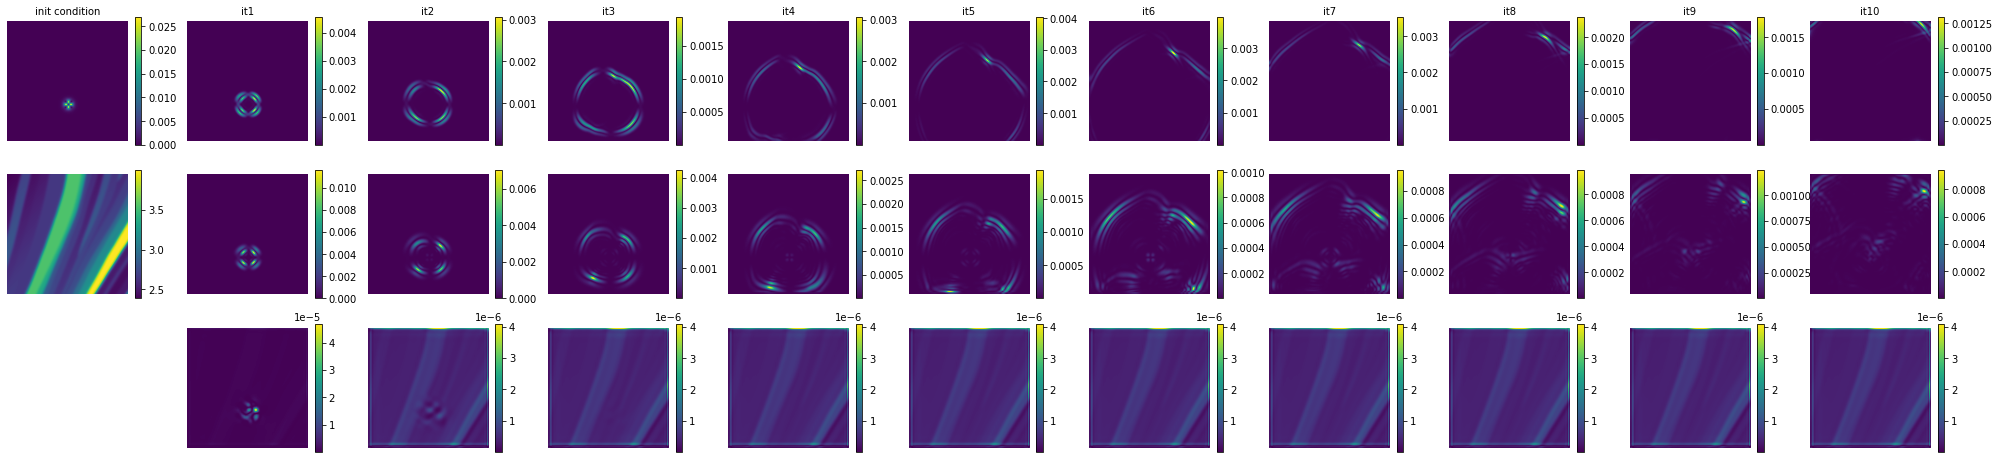

In [8]:
uc, utc = np.zeros([n_snaps-1,Nx,Ny]), np.zeros([n_snaps-1,Nx,Ny])
uf, utf = np.zeros([n_snaps-1,Nx,Ny]), np.zeros([n_snaps-1,Nx,Ny])
uo, uto = np.zeros([n_snaps-1,Nx,Ny]), np.zeros([n_snaps-1,Nx,Ny])

with torch.no_grad():
    for loader in loaders:
        for i, data in enumerate(loader):

            input = data[0].squeeze() # n_snaps x 4 x w x h
            fig = plt.figure(figsize=(35,8))

            #initial condition visualization
            u_x, u_y, u_t_c, vel = input[0, 0, :, :], input[0, 1, :, :], input[0, 2, :, :], input[0, 3, :, :]
            sumv = torch.sum(torch.sum(u_x))
            u, ut = wave_util.WaveSol_from_EnergyComponent_tensor(u_x.unsqueeze(dim=0), u_y.unsqueeze(dim=0), u_t_c.unsqueeze(dim=0), vel.unsqueeze(dim=0), dx, sumv)

            ax2 = fig.add_subplot(3,11,1)
            pos2 = ax2.imshow(wave_util.WaveEnergyField_tensor(u.squeeze(),ut.squeeze(),vel,dx)*dx*dx)
            ax2.set_title('init condition', fontsize=10)
            plt.colorbar(pos2)
            plt.axis('off')

            # velocity visualization
            ax1 = fig.add_subplot(3,11,12)
            vel_img = input[0, 3, :, :]
            pos1 = ax1.imshow(vel_img)
            plt.colorbar(pos1)
            plt.axis('off')

            #fine solver iteration
            for j in range(1,input.shape[0]):
                u_x, u_y, u_t_c, vel = input[j, 0, :, :], input[j, 1, :, :], input[j, 2, :, :], input[j, 3, :, :]  # w x h
                sumv = torch.sum(torch.sum(u_x))
                u, ut = wave_util.WaveSol_from_EnergyComponent_tensor(u_x.unsqueeze(dim=0), u_y.unsqueeze(dim=0), u_t_c.unsqueeze(dim=0), vel.unsqueeze(dim=0), dx, sumv)
                uf[j-1,:,:],utf[j-1,:,:]  = u.squeeze(), ut.squeeze()
                ax = fig.add_subplot(3,11,1+j)
                pos = ax.imshow(wave_util.WaveEnergyField_tensor(u.squeeze(),ut.squeeze(),vel,dx)*dx*dx)
                ax.set_title('it'+str(j), fontsize=10)
                plt.colorbar(pos)
                plt.axis('off')


            ufx, ufcx = wave_util.WaveSol_from_EnergyComponent_tensor(input[0, 0, :, :].unsqueeze(dim=0), input[0, 1, :, :].unsqueeze(dim=0), input[0, 2, :, :].unsqueeze(dim=0), input[0, 3, :, :].unsqueeze(dim=0), dx, sumv)
            #ufx, ufcx = ufx.numpy(), ufcx.numpy()
            for j in range(1,input.shape[0]):
                s_time_fine = time.time()
                ufx, ufcx = velocity_verlet_tensor(ufx, ufcx, vel.unsqueeze(dim=0), dx, dt, delta_t_star, number=1, boundary_c=boundary_c) #pseudo_spectral
                # ax = fig.add_subplot(3,11,1+j)
                # pos = ax.imshow(wave_util.WaveEnergyField_tensor(ufx.squeeze(),ufcx.squeeze(),vel,dx)*dx*dx)
                # plt.colorbar(pos)
                # plt.axis('off')
                e_time_fine = time.time()


            #coarse solver
            ucx, utcx = wave_util.WaveSol_from_EnergyComponent_tensor(input[0, 0, :, :].unsqueeze(dim=0), input[0, 1, :, :].unsqueeze(dim=0), input[0, 2, :, :].unsqueeze(dim=0), input[0, 3, :, :].unsqueeze(dim=0), dx, sumv)
            ucx, utcx = ucx.squeeze(), utcx.squeeze()
            for j in range(1,input.shape[0]):
                ucx, utcx,vel_c = torch.from_numpy(resize(ucx, [c_Nx,c_Nx], order=4)), torch.from_numpy(resize(utcx, [c_Nx,c_Nx], order=4)), torch.from_numpy(resize(vel, [c_Nx,c_Nx], order=4))
                s_time_coarse = time.time()
                ucx, utcx = velocity_verlet_tensor(
                    ucx.unsqueeze(dim=0), utcx.unsqueeze(dim=0),
                    vel_c.unsqueeze(dim=0), dX, dT, delta_t_star, number=1, boundary_c=boundary_c
                )
                e_time_coarse = time.time()
                ucx, utcx = ucx.squeeze(), utcx.squeeze()
                ucx, utcx = torch.from_numpy(resize(ucx, [Nx,Nx], order=4)), torch.from_numpy(resize(utcx, [Nx,Nx], order=4))
                uc[j-1,:,:],utc[j-1,:,:]  = ucx, utcx
                ax2 = fig.add_subplot(3,11,12+j)
                pos2 = ax2.imshow(wave_util.WaveEnergyField_tensor(ucx, utcx, vel, dx) * dx * dx)
                plt.colorbar(pos2)
                plt.axis('off')

            #restriction
            input_restr = input[0, :3, :, :].unsqueeze(dim=0)
            for j in range(1,input.shape[0]):
                input_restr = torch.concat([input_restr,vel_img.unsqueeze(dim=0).unsqueeze(0)],dim=1)
                s_time_endtoend = time.time()
                output = restr_model1(input_restr)  # b x 3 x w x h
                e_time_endtoend = time.time()
                u_x, u_y, u_t_c = output[:,0, :, :], output[:,1, :, :], output[:,2, :,:]
                sumv = torch.sum(torch.sum(u_x))
                u, ut = wave_util.WaveSol_from_EnergyComponent_tensor(u_x, u_y, u_t_c, vel, dt, sumv)
                uo[j-1,:,:], uto[j-1,:,:] = u.squeeze(), ut.squeeze()
                ax3 = fig.add_subplot(3,11,23+j)
                pos3 = ax3.imshow(wave_util.WaveEnergyField_tensor(u.squeeze(), ut.squeeze(), vel, dx) * dx * dx)
                plt.colorbar(pos3)
                plt.axis('off')
                input_restr = output.clone()

            break
        break

In [6]:
# time difference
print("time coarse solver:", e_time_coarse - s_time_coarse)
print("time fine solver:", e_time_fine - s_time_fine)
print("time end to end solver:", e_time_endtoend - s_time_endtoend)

time coarse solver: 0.015787124633789062
time fine solver: 0.0706031322479248
time end to end solver: 0.06549501419067383


In [9]:
0.11210012435913086/0.013200688362121581

8.491990817751145

In [10]:
0.11518535614013672/0.023014593124389648

5.004883445802454

In [11]:
0.34736311435699463/0.036183857917785646

9.599946891960721

In [19]:
# compare wave energy norm errors:

from sklearn.metrics import mean_squared_error, mean_absolute_error
from tabulate import tabulate

table = [["snapshot", "MSE coarse", "MSE end to end", "MAE coarse", "MAE end to end"]]

for it in range(1,10):
    wf = wave_util.WaveEnergyField(uf[it,:,:], utf[it,:,:], vel.numpy(), dx)*dx*dx
    w1 = wave_util.WaveEnergyField(uc[it,:,:], utc[it,:,:], vel.numpy(), dx)*dx*dx
    w2 = wave_util.WaveEnergyField(uo[it,:,:], uto[it,:,:], vel.numpy(), dx)*dx*dx

    mse1 = mean_squared_error(wf, w1)
    mse2 = mean_squared_error(wf, w2)

    mae1 = mean_absolute_error(wf, w1)
    mae2 = mean_absolute_error(wf, w2)

    table.append([it, mse1, mse2, mae1,mae2])

print("compare fine solver result to implementation:")
print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))

compare fine solver result to implementation:
╒════════════╤══════════════╤══════════════════╤══════════════╤══════════════════╕
│   snapshot │   MSE coarse │   MSE end to end │   MAE coarse │   MAE end to end │
╞════════════╪══════════════╪══════════════════╪══════════════╪══════════════════╡
│          1 │  1.13391e-07 │      4.55226e-08 │  5.8608e-05  │      4.32583e-05 │
├────────────┼──────────────┼──────────────────┼──────────────┼──────────────────┤
│          2 │  7.21983e-08 │      2.85713e-08 │  6.72576e-05 │      4.1579e-05  │
├────────────┼──────────────┼──────────────────┼──────────────┼──────────────────┤
│          3 │  5.24044e-08 │      3.12826e-08 │  7.04133e-05 │      4.20402e-05 │
├────────────┼──────────────┼──────────────────┼──────────────┼──────────────────┤
│          4 │  3.80051e-08 │      2.75175e-08 │  6.04884e-05 │      3.67421e-05 │
├────────────┼──────────────┼──────────────────┼──────────────┼──────────────────┤
│          5 │  2.81177e-08 │      2.1640